# Projet : Paris smart-city

In [26]:
import numpy as np
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
#%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
df = pd.read_csv('p2-arbres-fr.csv', delimiter = ';')

#### 1. Présentation et nettoyage des données

In [23]:
if 'type_emplacement' in df.columns:
    df.drop(columns=['type_emplacement', 'numero', 'id_emplacement', 'complement_addresse'], inplace=True)
    df.variete = df.variete.fillna('Manquante')
    df['variete'] = df['variete'].apply(lambda x: x[:-1] if x.endswith("'") else x)
    df_brut = df.copy()
    # debatable
    df = df.dropna(subset=['domanialite'])
    df.remarquable = df.remarquable.apply(lambda x : 1 if x == 1 else 0)

    
    
    hauteur_reccord = 31
    circonference_reccord = 700

    df_sans_outlier_hauteur = df.loc[df.hauteur_m <= hauteur_reccord, :]
    df_sans_outlier = df_sans_outlier_hauteur.loc[df_sans_outlier_hauteur.circonference_cm <= circonference_reccord, :]
    df_sans_outlier.head()

#### 2. Analyse

* Taux d\'arbre remarquable pour les 10 genres d\'arbres les plus plantés dans Paris

In [24]:
remarquable_per_genre_df = df.groupby(['genre'])['remarquable'].sum().sort_values(ascending=False)
remarquable_per_genre_df = remarquable_per_genre_df[remarquable_per_genre_df>=5]
temp_serie = df[df['genre'].isin(remarquable_per_genre_df[remarquable_per_genre_df > 0].index)]\
.genre.value_counts().sort_values(ascending=False)
print('Taux d\'arbre remarquable pour les 10 genres d\'arbres les plus plantés dans Paris')

percentage_remarquable_df = pd.DataFrame(remarquable_per_genre_df.div(temp_serie)*100, columns = ['%'],\
             index=temp_serie.sort_values(ascending=False).index).head(10)
percentage_remarquable_df["nombre d'arbre par genre"] = temp_serie
percentage_remarquable_df["nombre d'arbre remarquable par genre"] = remarquable_per_genre_df

percentage_remarquable_df


Taux d'arbre remarquable pour les 10 genres d'arbres les plus plantés dans Paris


,%,nombre d'arbre par genre,nombre d'arbre remarquable par genre
genre,,,
Platanus,0.075133,42591,32
Aesculus,0.039462,25341,10
Acer,0.032483,18471,6
Quercus,0.282995,3887,11
Corylus,0.202137,3463,7
Fagus,0.622084,1929,12
Pterocarya,0.700000,1000,7
Ginkgo,0.851064,940,8
Cedrus,0.878156,911,8


L'échantillon étant très faible, le maximum d'arbre remarquable par genre d'arbre étant 32 platanes, si on veut maximiser les chances de produires des arbres remarquable à Paris il peut être intéressant de planter l'un de ces genres d'abres qui ne sont pas des cas isolés (au moins 5 instances d'arbre remarquable recensés).


On ne peut pas se contenter de dire qu'il faut planter un maximum de Diospyros pour maximiser ces chances, les Platanus, les Quercus et les Fagus semblent semblent être préférable car l'échantillon d'arbre de ces genres présent à Paris est important et ils sont qualifiés de remarquables à une fréquence intéressante.

* Domanialite / genre

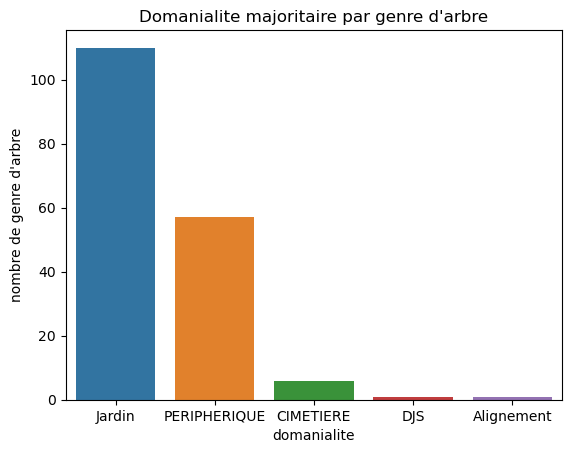

In [28]:
max_values_dict = {genre: max_value for genre, max_value in df.groupby('genre')['domanialite'].max().items()}
top_dom_per_genre = pd.DataFrame(max_values_dict.items(), columns = ['genre', 'domanialite']).domanialite.value_counts()
sns.barplot(x=top_dom_per_genre.index, y=top_dom_per_genre.values)
plt.title("Domanialite majoritaire par genre d'arbre")
plt.ylabel("nombre de genre d'arbre")
plt.show()

* hauteur/circonference et stade de developpement

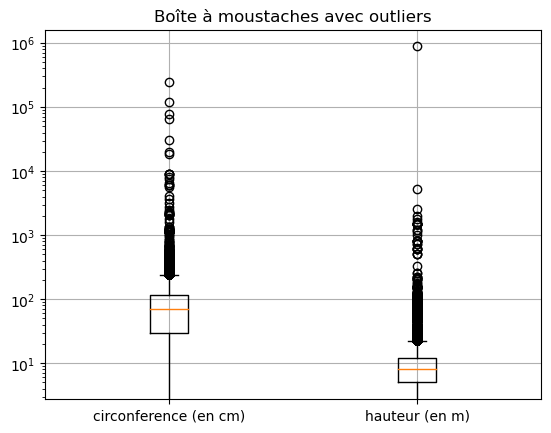

In [6]:
circonference = df['circonference_cm']
hauteur = df['hauteur_m']
plt.boxplot([circonference, hauteur], showfliers=True) 
plt.xticks([1, 2], ['circonference (en cm)', 'hauteur (en m)'])
plt.yscale('log')
plt.title("Boîte à moustaches avec outliers")
plt.grid(True)
plt.show()

On définit le reccord de l'arbre le plus grand en taille et circonférence et on retire les valeurs au dessus

In [8]:
hauteur_reccord = 31
circonference_reccord = 700

df_sans_outlier_hauteur = df.loc[df.hauteur_m <= hauteur_reccord, :]
df_sans_outlier = df_sans_outlier_hauteur.loc[df_sans_outlier_hauteur.circonference_cm <= circonference_reccord, :]

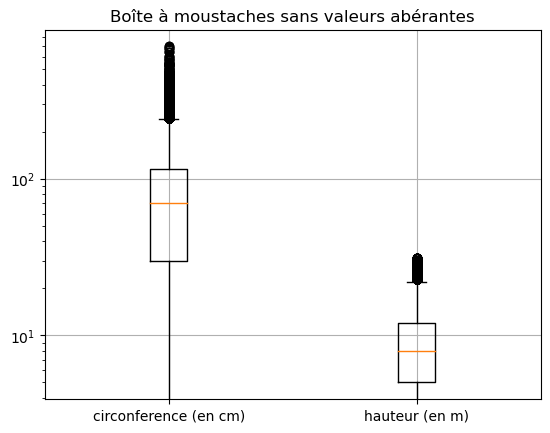

In [9]:
circonference = df_sans_outlier['circonference_cm']
hauteur = df_sans_outlier['hauteur_m']
plt.boxplot([circonference, hauteur], showfliers=True) 
plt.xticks([1, 2], ['circonference (en cm)', 'hauteur (en m)'])
plt.yscale('log')
plt.title("Boîte à moustaches sans valeurs abérantes")
plt.grid(True)
plt.show()

On va pouvoir maintenant se servir des données hauteur et circonférence pour établir certains processus de renouvellement des arbres.

In [10]:
print(round((1-df['stade_developpement'].dropna().shape[0]/df['stade_developpement'].shape[0])*100,1)
      ,'% de valeurs manquantes dans "stade_developpement"')

33.6 % de valeurs manquantes dans "stade_developpement"


Il y a beaucoup de valeurs manquantes dans cette colonne, elle va être difficilement exploitable. Il faut soit établir une stratégie d'imputation pour compléter les valeurs manquantes, soit abandonner cette colonne.

In [13]:
remarquable_per_genre_df = df_sans_outlier.groupby(['genre'])['remarquable'].sum().sort_values(ascending=False)
remarquable_per_genre_df = remarquable_per_genre_df[remarquable_per_genre_df>1]
temp_serie = df_sans_outlier[df_sans_outlier['genre'].isin(remarquable_per_genre_df[remarquable_per_genre_df > 0].index)]\
.genre.value_counts().sort_values()
print("Part d'arbres remarquables parmi les différents genres.")

pd.DataFrame(remarquable_per_genre_df.div(temp_serie)*100, columns = ['%'],\
             index=temp_serie.sort_values(ascending=False).index)

Part d'arbres remarquables parmi les différents genres.


,%
genre,
Platanus,0.061282
Aesculus,0.039537
Acer,0.032531
Sophora,0.016933
Pinus,0.082406
Celtis,0.048792
Quercus,0.257865
Corylus,0.202488
Ulmus,0.140713


On va appliquer une méthode d'imputation pour les cinq premiers arbres de la liste ci-dessus. En effet les arbres remarquables faussent les stats, il est donc préférable d'étudier un échantillon avec un faible taux d'arbres remarquables.

In [14]:
def attribuer_stade_arbre(espece, taille, circonference):
    if espece == 'Platanus':
        if taille <= 10:
            return 'J'
        elif 10 < taille <= 20:
            return 'JA'
        elif 20 < taille <= 25:
            return 'A'
        else:
            return 'M'
    elif espece == 'Aesculus':
        if taille <= 10 and circonference <= 100:
            return 'J'
        elif 10 < taille <= 20 and 60 < circonference <= 200:
            return 'JA'
        elif 15 < taille <= 35 and 100 < circonference <= 400:
            return 'A'
        else:
            return 'M'
    elif espece == 'Acer' or espece == 'Sophora':
        if taille <= 8 and circonference <= 30:
            return 'J'
        elif 8 < taille <= 15 and 30 < circonference <= 100:
            return 'JA'
        elif 15 < taille <= 25 and 100 < circonference <= 200:
            return 'A'
        else:
            return 'M'
    elif espece == 'Pinus':
        if taille <= 5 and circonference <= 15:
            return 'J'
        elif 5 < taille <= 15 and 15 < circonference <= 30:
            return 'JA'
        elif 15 < taille <= 45 and 30 < circonference <= 100:
            return 'A'
        else:
            return 'M'
   

In [16]:
df2 = df.copy()
df2['stade_developpement'] = df2.apply(lambda row: attribuer_stade_arbre(row['genre'], row['hauteur_m'], row['circonference_cm']), axis=1)